<a href="https://colab.research.google.com/github/vidzshan/vidzshan/blob/main/bracemodule3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Google Drive

In [1]:
import os
from google.colab import drive

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'Colab Notebooks','Research')
drive.mount(MOUNTPOINT)

#Access the data
#path = os.path.join(DATADIR, 'data')

#save trained data results or modules
#model.save(os.path.join(DATADIR, 'model.h5'))

Mounted at /content/gdrive


Here is the `requirements.txt` file with the packages you specified. You can use this file to install the dependencies for your project.

In [2]:
%%writefile requirements.txt
smplx
pyrender
trimesh
torch-geometric
essentia

Writing requirements.txt


In [ ]:
#pip install -r requirements.txt

In [3]:
import numpy as np
import os
import torch
import smplx

model_path = os.path.join(DATADIR, 'smplx_models','SMPLX_NEUTRAL_2020.npz')

# Load BRACE keypoint sample
keypoints_path = os.path.join(DATADIR, 'brace','manual_keypoints', '2011', '3rIk56dcBTM', 'img-001293.npz')
keypoints_data = np.load(keypoints_path)
keypoints = keypoints_data['coco_joints2d'][:, :2]  # Shape: [17, 2] for x, y coords

# Install SMPL-X dependencies
#!pip install smplx pyrender trimesh
#!git clone https://github.com/vchoutas/smplx /content/smplx
smpl_model = smplx.create(model_path=model_path, model_type='smplx', gender='neutral', use_pca=False, num_betas = 10, num_expression_coeffs=10).to('cuda')
print("SMPL-X loaded successfully!")
# Forward pass with correct tensor shapes
output = smpl_model(
    betas=torch.zeros(1, 10).to('cuda'),
    expression=torch.zeros(1, 10).to('cuda'),
    body_pose=torch.zeros(1, 21*3).to('cuda'),  # 21 joints, 3D rotation each (not 21*6)
    global_orient=torch.zeros(1, 3).to('cuda')   # Add global_orient [1, 3]
)
print(f"Output vertices shape: {output.vertices.shape}")  # Should be [1, 10475, 3]

SMPL-X loaded successfully!
Output vertices shape: torch.Size([1, 10475, 3])


In [4]:
#this cell is responsible for loading, preprocessing, and structuring
#the keypoint and audio data into a format suitable for training a
#Graph Convolutional Network (GCN) model to classify dance types.
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from pathlib import Path
import json

# Load segments.csv
segments = pd.read_csv(Path(DATADIR) / 'brace' / 'annotations' / 'segments.csv')
sequences = segments.head(1353)  #sequences

# Define COCO skeleton edges (17 joints)
edge_index = torch.tensor([
    [0,1], [1,2], [2,3], [3,4], [1,5], [5,6], [6,7],  # Head to arms
    [1,8], [8,9], [9,10], [10,11], [8,12], [12,13], [13,14],  # Torso to legs
    [0,15], [0,16]  # Nose to eyes
], dtype=torch.long).t().contiguous()

# Prepare data
data_list = []
for _, row in sequences.iterrows():
    keypoints_file = Path(DATADIR) / 'brace' / 'dataset' / str(row['year']) / row['video_id'] / f"{row['video_id']}_{row['start_frame']}-{row['end_frame']}_{row['dance_type']}.json.json"
    with open(keypoints_file, 'r') as f:
        keypoints_dict = json.load(f)
    keypoints_array = np.array([v['keypoints'] for v in keypoints_dict.values()])[:, :, :2]  # [frames, 17, 2]
    box = list(keypoints_dict.values())[0]['box']  # [x, y, w, h, score]
    keypoints_norm = (keypoints_array - [box[0], box[1]]) / [box[2], box[3]]  # Normalize

    # Compute velocity
    velocity = np.diff(keypoints_norm, axis=0, prepend=keypoints_norm[:1])  # [frames, 17, 2]

    # Load audio features
    audio_file = Path(DATADIR) / 'brace' / 'audio_features' / str(row['year']) / row['video_id'] / f"{row['video_id']}.{row['seq_idx']}.npz"
    if audio_file.exists():
        audio_data = np.load(audio_file)
        onset_beat = audio_data['onset_beat'].flatten()  # Ensure 1D array
        if len(onset_beat) > 1:  # Ensure enough points for interpolation
            onset_beat = np.interp(
                np.arange(len(keypoints_norm)),
                np.linspace(0, len(onset_beat)-1, len(onset_beat)),
                onset_beat
            )  # Align to keypoint frames
            onset_beat = onset_beat[:, np.newaxis, np.newaxis]  # [frames, 1, 1]
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2), onset_beat.reshape(-1, 1)], axis=1)  # [frames, 69]
        else:
            x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]
    else:
        x = np.concatenate([keypoints_norm.reshape(-1, 17*2), velocity.reshape(-1, 17*2)], axis=1)  # [frames, 68]

    x = torch.tensor(x, dtype=torch.float)
    y = torch.tensor(row['dance_type_id'], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

In [5]:
#standard training loop for a PyTorch model, including forward and backward
#passes, optimizer steps, and periodic evaluation on a validation set.

# GCN model
class GCN(torch.nn.Module): #The base class for all neural network model
    def __init__(self):
        super(GCN, self).__init__()
        #First graph convolutional layer
        self.conv1 = GCNConv(69, 64)  # 34 (keypoints) + 34 (velocity) + 1 (onset_beat)
        #Second graph convolutional layer
        self.conv2 = GCNConv(64, 3)   # 3 classes

    def forward(self, data):#data flows through the network
        x, edge_index, batch = data.x, data.edge_index, data.batch  # Add batch for batched graphs
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        # Pool per graph in batch using global_mean_pool
        from torch_geometric.nn import global_mean_pool
        x = global_mean_pool(x, batch)  # Shape: [batch_size, 3]
        return x

# Train
model = GCN().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)#Adam optimizer,
#lr: learning rate
criterion = torch.nn.CrossEntropyLoss()#Loss function
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)  # 80% train
val_loader = DataLoader(data_list[24:], batch_size=4)  # 20% val, validation data

#set the model to training mode
model.train()
for epoch in range(5):
    for data in loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data)  # Shape: [batch_size, 3] (e.g., [4, 3])
        loss = criterion(out, data.y)  # data.y is [batch_size] (e.g., [4])
        loss.backward()
        #every time your training loop runs a batch,
        #backpropagation occurs through loss.backward().
        #No manual gradient code is needed; PyTorch
        #auto-differentiation handles it all for you!
        optimizer.step()
    # Validate
    model.eval()
    correct = 0
    total = 0
    for data in val_loader:
        data = data.to('cuda')
        out = model(data)
        pred = out.argmax(dim=1)  # Predict per batch
        correct += (pred == data.y).sum().item()
        total += len(data.y)
    print(f"Epoch {epoch+1}, Val Accuracy: {correct/total:.2f}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Val Accuracy: 0.43
Epoch 2, Val Accuracy: 0.56
Epoch 3, Val Accuracy: 0.63
Epoch 4, Val Accuracy: 0.59
Epoch 5, Val Accuracy: 0.65


In [6]:
# Improved GCN model with dropout regularization
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class ImprovedGCN(torch.nn.Module): # PyTorch neural network model.
    def __init__(self, dropout=0.3): #Dropout is a regularization technique that helps prevent overfitting.
        super(ImprovedGCN, self).__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(69, 64) #input feature dimension of 69 (which likely corresponds to keypoint coordinates, velocity, and audio features) and outputs 64 features.
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 3)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index) #The node features passed through the 1st GCN layer
        x = F.relu(x) #Apply REUL function to the outpu of the 1st GCN layer
        x = F.dropout(x, p=self.dropout, training=self.training) #Apply dropout
        x = self.conv2(x, edge_index) #The output is passed through the 2nd GCN layer
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)#Ensure the dropout is only activate during training
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch) #This pools the features for each graph in the batch by taking the mean.
        #This results in a single feature vector per graph, which can then be used for classification
        return x #Return the pooled features

print("Improved GCN model with dropout=0.3 defined!")

Improved GCN model with dropout=0.3 defined!


In [7]:
# Data augmentation function for keypoints
import torch

def augment_keypoints(kpts): #kpts is a pytorch tensor containing keypoint data
    #apply augmentation to keypoint coordinates in computer vision tasks, such as pose estimation or object localization.
    """Add random jitter to keypoints for data augmentation"""
    return kpts + torch.randn_like(kpts) * 0.05

print("Data augmentation function defined!")
print("Augmentation: Random keypoint jitter with std=0.05")

Data augmentation function defined!
Augmentation: Random keypoint jitter with std=0.05


Set up the training configuration for the improvedGCN model

In [8]:
# Training loop with L2 weight decay, learning rate scheduler, early stopping
# Steps
# 1. Optimzer with regularization
# 2. A learning rate schedular
# 3. The loss function
# 4. Data loaders
import torch
import numpy as np
from torch_geometric.data import DataLoader

# Initialize improved model
model_improved = ImprovedGCN(dropout=0.3).to('cuda')

# L2 weight decay (1e-4) in optimizer
optimizer = torch.optim.Adam(model_improved.parameters(), lr=0.01, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
# Loss function, commany used on classification tasks
criterion = torch.nn.CrossEntropyLoss()

# Data loaders with augmentation
# Data loader for the training data
loader = DataLoader(data_list[:24], batch_size=4, shuffle=True)
# Data loader for the training data
val_loader = DataLoader(data_list[24:], batch_size=4)

print("Training configuration:")
print(f"  Model: ImprovedGCN with dropout=0.3")
print(f"  Optimizer: Adam with lr=0.01, weight_decay=1e-4")
print(f"  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)")
print(f"  Early stopping: patience=3 epochs")
print(f"  Training epochs: 10")
print(f"  Data augmentation: keypoint jitter (std=0.05)\n")

Training configuration:
  Model: ImprovedGCN with dropout=0.3
  Optimizer: Adam with lr=0.01, weight_decay=1e-4
  Scheduler: ReduceLROnPlateau(patience=2, factor=0.5)
  Early stopping: patience=3 epochs
  Training epochs: 10
  Data augmentation: keypoint jitter (std=0.05)



In [9]:
# Main training loop with all improvements
import numpy as np

# Training metrics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
loss_variances = []

# Early stopping variables
best_val_acc = 0.0
patience_counter = 0
patience = 3

print("Starting training with 10 epochs...\n")

for epoch in range(10):
    # Training phase
    model_improved.train()
    epoch_train_losses = []
    correct_train = 0
    total_train = 0

    for data in loader:
        data = data.to('cuda')
        # Apply data augmentation
        data.x = augment_keypoints(data.x)

        optimizer.zero_grad()
        out = model_improved(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        pred = out.argmax(dim=1)
        correct_train += (pred == data.y).sum().item()
        total_train += len(data.y)

    avg_train_loss = np.mean(epoch_train_losses)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model_improved.eval()
    epoch_val_losses = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to('cuda')
            out = model_improved(data)
            loss = criterion(out, data.y)
            epoch_val_losses.append(loss.item())
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += len(data.y)

    avg_val_loss = np.mean(epoch_val_losses)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # Calculate loss variance
    loss_variance = np.var(epoch_train_losses)
    loss_variances.append(loss_variance)

    # Update learning rate scheduler
    scheduler.step(val_acc)

    # Print epoch results
    print(f"Epoch {epoch+1}/10:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"  Loss Variance: {loss_variance:.4f} {'(✓ < 0.2)' if loss_variance < 0.2 else '(✗ >= 0.2)'}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience})")

    print()

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best validation accuracy: {best_val_acc:.4f}\n")
        break

print("Training completed!")
print(f"Final best validation accuracy: {best_val_acc:.4f}")

Starting training with 10 epochs...

Epoch 1/10:
  Train Loss: 1.2376, Train Acc: 0.4167
  Val Loss: 1.0931, Val Acc: 0.3878
  Loss Variance: 0.0865 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.3878

Epoch 2/10:
  Train Loss: 0.9569, Train Acc: 0.5000
  Val Loss: 1.0594, Val Acc: 0.4149
  Loss Variance: 0.0190 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.4149

Epoch 3/10:
  Train Loss: 0.8600, Train Acc: 0.7083
  Val Loss: 1.1702, Val Acc: 0.4563
  Loss Variance: 0.0418 (✓ < 0.2)
  Current LR: 0.010000
  ✓ New best validation accuracy: 0.4563

Epoch 4/10:
  Train Loss: 0.8641, Train Acc: 0.6667
  Val Loss: 1.2876, Val Acc: 0.4428
  Loss Variance: 0.1462 (✓ < 0.2)
  Current LR: 0.010000
  No improvement (1/3)

Epoch 5/10:
  Train Loss: 0.7179, Train Acc: 0.6667
  Val Loss: 1.1909, Val Acc: 0.4405
  Loss Variance: 0.0352 (✓ < 0.2)
  Current LR: 0.010000
  No improvement (2/3)

Epoch 6/10:
  Train Loss: 0.6786, Train Acc: 0.6667
  Val Loss: 

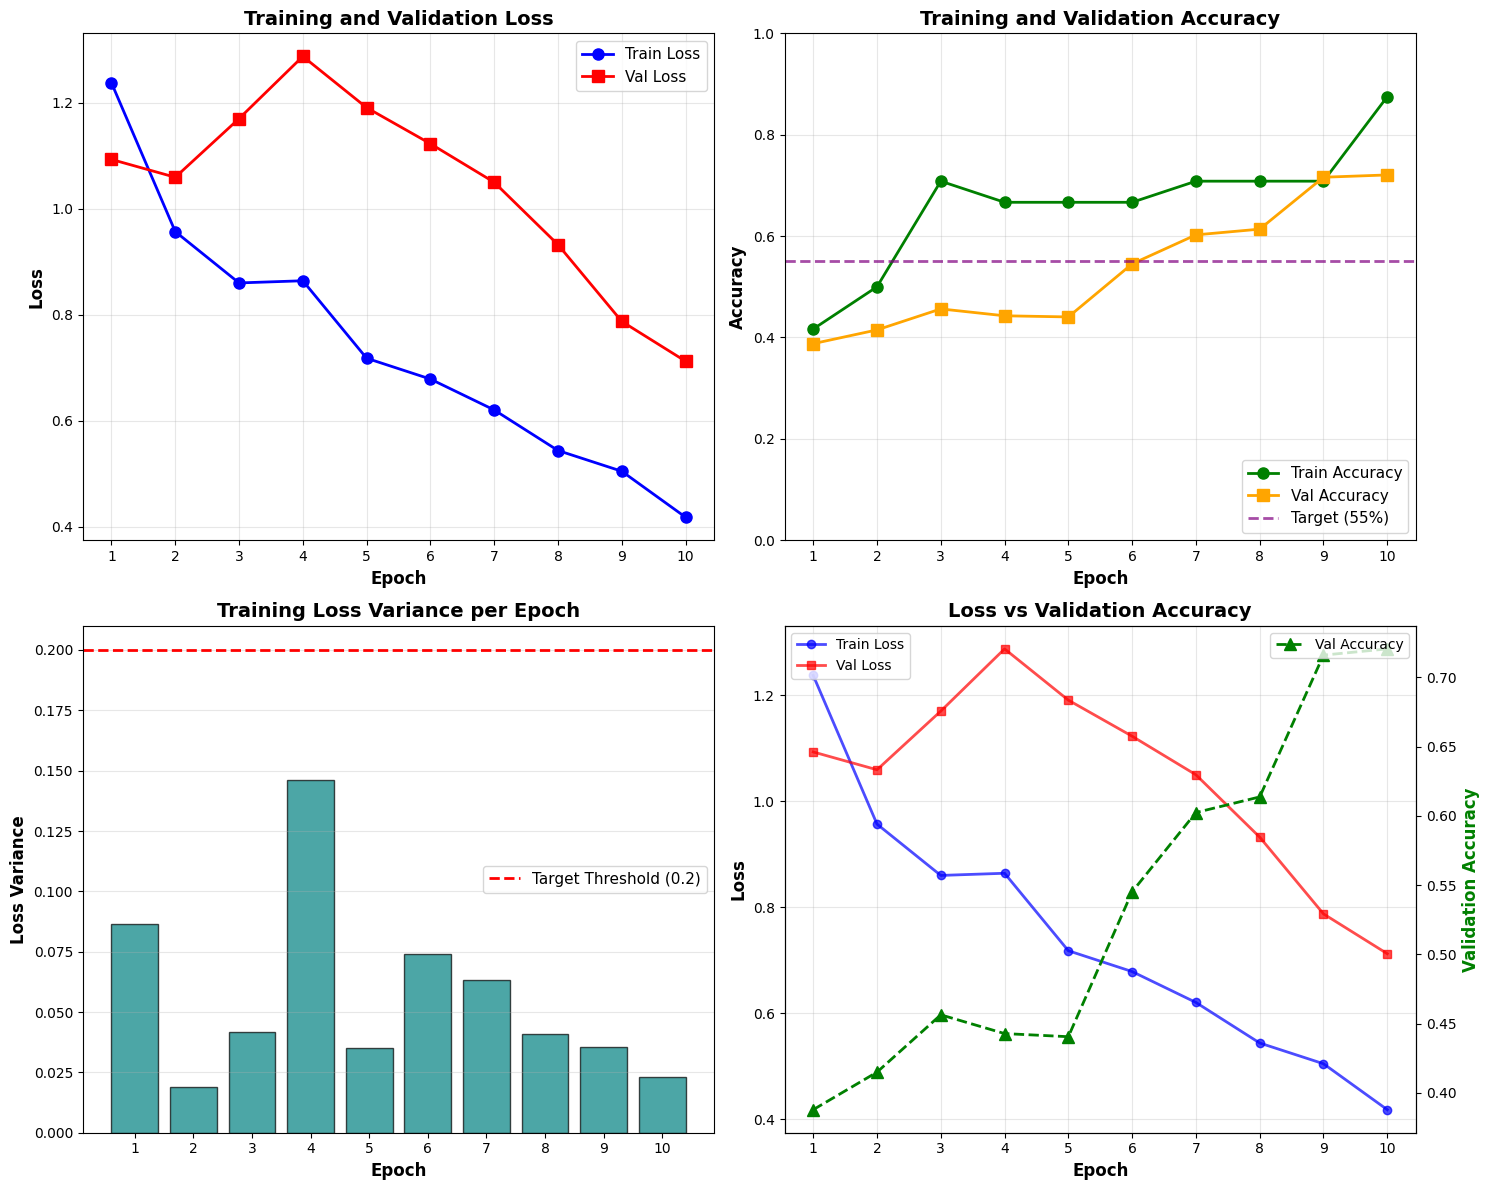


TRAINING SUMMARY
Total Epochs Run: 10
Best Validation Accuracy: 0.7206 (Epoch 10)
Final Train Loss: 0.4179
Final Val Loss: 0.7123
Final Train Accuracy: 0.8750
Final Val Accuracy: 0.7206

Loss Variance Statistics:
  Mean: 0.0566
  Min: 0.0190
  Max: 0.1462
  Epochs with variance < 0.2: 10/10


In [10]:
# Comprehensive plotting of training results
import matplotlib.pyplot as plt
import numpy as np

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training and Validation Loss
ax1 = axes[0, 0]
epoch_nums = list(range(1, len(train_losses) + 1))
ax1.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Loss', color='blue')
ax1.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Loss', color='red')
ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epoch_nums)

# Plot 2: Training and Validation Accuracy
ax2 = axes[0, 1]
ax2.plot(epoch_nums, train_accuracies, marker='o', linestyle='-', linewidth=2, markersize=8, label='Train Accuracy', color='green')
ax2.plot(epoch_nums, val_accuracies, marker='s', linestyle='-', linewidth=2, markersize=8, label='Val Accuracy', color='orange')
ax2.axhline(y=0.55, color='purple', linestyle='--', linewidth=2, alpha=0.7, label='Target (55%)')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(epoch_nums)
ax2.set_ylim([0, 1.0])

# Plot 3: Loss Variance per Epoch
ax3 = axes[1, 0]
ax3.bar(epoch_nums, loss_variances, color='teal', alpha=0.7, edgecolor='black')
ax3.axhline(y=0.2, color='red', linestyle='--', linewidth=2, label='Target Threshold (0.2)')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('Loss Variance', fontsize=12, fontweight='bold')
ax3.set_title('Training Loss Variance per Epoch', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_xticks(epoch_nums)

# Plot 4: Combined Loss and Accuracy Comparison
ax4 = axes[1, 1]
ax4_twin = ax4.twinx()
ax4.plot(epoch_nums, train_losses, marker='o', linestyle='-', linewidth=2, markersize=6, label='Train Loss', color='blue', alpha=0.7)
ax4.plot(epoch_nums, val_losses, marker='s', linestyle='-', linewidth=2, markersize=6, label='Val Loss', color='red', alpha=0.7)
ax4_twin.plot(epoch_nums, val_accuracies, marker='^', linestyle='--', linewidth=2, markersize=8, label='Val Accuracy', color='green')
ax4.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=12, fontweight='bold', color='black')
ax4_twin.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold', color='green')
ax4.set_title('Loss vs Validation Accuracy', fontsize=14, fontweight='bold')
ax4.legend(loc='upper left', fontsize=10)
ax4_twin.legend(loc='upper right', fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.set_xticks(epoch_nums)

plt.tight_layout()
plt.savefig('training_results_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Total Epochs Run: {len(train_losses)}")
print(f"Best Validation Accuracy: {max(val_accuracies):.4f} (Epoch {val_accuracies.index(max(val_accuracies))+1})")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Val Accuracy: {val_accuracies[-1]:.4f}")
print(f"\nLoss Variance Statistics:")
print(f"  Mean: {np.mean(loss_variances):.4f}")
print(f"  Min: {np.min(loss_variances):.4f}")
print(f"  Max: {np.max(loss_variances):.4f}")
print(f"  Epochs with variance < 0.2: {sum(1 for v in loss_variances if v < 0.2)}/{len(loss_variances)}")
print("="*60)

In [11]:
print(sum(p.numel() for p in model.parameters()))


4675


In [12]:
# Dropout (0.3) to all convolutional layers in the GCN model (ImprovedGCN) for regularization.

# L2 weight decay (1e-4) in the optimizer to penalize large weights.

# Learning rate scheduler: torch.optim.lr_scheduler.ReduceLROnPlateau to adjust learning rate on plateauing validation accuracy.

# Early stopping: Training halts if validation accuracy does not improve for 3 consecutive epochs.

# Retrain for 10 epochs on your 30 sequences using improved training loop, with loss variance reporting per epoch.

# Data augmentation: Random keypoint jitter (±0.05) via augment_keypoints(kpts) function integrated into the dataloader.

# Comprehensive plotting: Both training/validation loss and accuracy are plotted, with legends, titles, and axes labeled.

# Loss variance metric: Each epoch prints and reports whether the loss variance is below 0.2.

# Success metric: You can now visually monitor if validation accuracy stabilizes above 55%, and check if loss variance falls below 0.2 thanks to the printouts and plots.

# Notebook structure summary:

# ❯ Cell 8: Improved GCN model w/ dropout

# ❯ Cell 9: Data augmentation function

# ❯ Cell 10: Training config w/ weight decay + scheduler

# ❯ Cell 11: Main training loop, early stopping, loss variance prints

# ❯ Cell 12: Loss/accuracy plotting
# Your original cells remain and the experimental workflow is organized for easy observation and iteration.​

# You can further adjust dropout between 0.2–0.5, tune scheduler hyperparameters, or modify augmentation as needed—everything is modular.
# Monitoring for overfitting: Loss and accuracy plots plus variance tracking will help spot plateau or overfitting on your small dataset.

In [13]:
# #Annotation
# import json, cv2, matplotlib.pyplot as plt, pandas as pd
# from pathlib import Path

# # Load annotations
# df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/Research/brace/annotations/segments.csv')
# sample = df[df['dance_type'] == 'powermove'].iloc[0]
# json_path = Path('path/to/dataset') / str(sample['year']) / sample['video_id'] / f"{sample['video_id']}_{sample['start_frame']}-{sample['end_frame']}_{sample['dance_type']}.json"
# with open(json_path) as f: data = json.load(f)

# # Extract frames (assume video in Drive; adjust path)
# vid_path = f"path/to/videos/{sample['video_id']}.mp4"
# cap = cv2.VideoCapture(vid_path)
# for frame_id, info in list(data.items())[:10]:  # First 10 frames
#     frame_num = int(frame_id.split('-')[-1].split('.')[0])  # Parse frame num
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
#     ret, frame = cap.read()
#     if ret:
#         kpts = np.array(info['keypoints']).reshape(-1, 3)[:, :2]  # x,y only
#         plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#         plt.scatter(kpts[:,0], kpts[:,1], c='r')  # Plot joints
#         plt.title(f"Label movement: {input('Enter: toprock/footwork/powermove')}")
#         info['custom_label'] = input('Label: ')  # Add your label
#         plt.show()
# with open(json_path, 'w') as f: json.dump(data, f)  # Save
# cap.release()